# Dunkin assessment

In [230]:
# some imports used throughout script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [231]:
def encode_biscuit_type(dataframe, biscuits):
    """
    Add new column to dataframe, changing biscuit names to integers. 

    Args:
        dataframe (df): dataframe containing 'biscuit' column
        biscuits (list): list of biscuit names in correct order
    """
    # check biscuit column exists
    # do a test?
    try:
        biscuit_column = dataframe['biscuit']
    
        for i, biscuit in enumerate(biscuits):
            biscuit_column = np.where([biscuit_column==biscuit], i, biscuit_column)[0]
            print(biscuit_column)
            
        # set values to ints
        dataframe['encoded biscuit'] = pd.to_numeric(biscuit_column)
        
        print("added encoded biscuit column")
        
    except:
        raise ValueError("\"biscuit\" column does not exist in this dataframe.")

In [232]:
def washburn(gamma,phi,eta,r,t):
    """
    Function to calculate L using the washburn equation. 

    Args:
        gamma (float): tea surface tension, in N m^(-1).
        phi (float): contact angle between the biscuit and the tea surface, in rad.
        eta (float):  tea dynamic viscosity, in Pa s
        r (float): radius of the pore, in m
        t (float): time after initial dunking that the measurement was made, in s.

    Returns:
        L (float): distance up the biscuit that the tea was visible, in m.
    """
    
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    return L

#### Big data collection

1. gamma: the tea surface tension, in N m−1
.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. biscuit: the type of biscuit that was dunked, which is Rich Tea, Hobnob or Digestive.


In [233]:
# load in dunking-data, and show dataframe

big_data = pd.read_csv("dunking-data.csv")
print(f"shape: {big_data.shape}")
big_data.head()

shape: (3000, 6)


,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [234]:
# get names of all types of biscuits

biscuits = np.unique(big_data["biscuit"])
biscuits

array(['Digestive', 'Hobnob', 'Rich Tea'], dtype=object)

In [235]:
# encode names to integers

encode_biscuit_type(big_data, biscuits)
big_data['encoded biscuit']

[0 0 0 ... 'Hobnob' 0 'Rich Tea']
[0 0 0 ... 1 0 'Rich Tea']
[0 0 0 ... 1 0 2]
added encoded biscuit column


0       0
1       0
2       0
3       1
4       1
       ..
2995    0
2996    1
2997    1
2998    0
2999    2
Name: encoded biscuit, Length: 3000, dtype: int64

# Classification of biscuit type 

In this section, a ML classifier is trained and tested on the dunking-data.csv. It aims to be able to classify biscuit type from the provided data (phi,eta,L,t).

GridSearchCV is used to determine the best hyperparameters for two models - random forest classifier, and support vector classification (SVC), and then use the better performing model throughout the rest of the script.



In [236]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train, test = train_test_split(big_data, test_size=0.4)

# scale data
scaler = StandardScaler()
scaled_training_features = scaler.fit_transform(train.drop(['biscuit', 'encoded biscuit'], axis=1))
scaled_test_features = scaler.fit_transform(test.drop(['biscuit', 'encoded biscuit'], axis=1))

training_results = train['encoded biscuit']
true_test_vals = test['encoded biscuit']

In [237]:
# use GridSearchCV
rfc_param_grid = [
    {'n_estimators': [50, 1000]},
  {'max_features': [ None]}
 ]

svc_param_grid = [
  {'C': [5000, 1000, 100, 10, 5],  
  'gamma': [0.001, 0.01, 0.1, 8, 'scale', 'auto'], 
  'kernel': ['rbf']} 
 ]

In [238]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

methods = {'Random Forest': [RandomForestClassifier(), rfc_param_grid], 'SVM': [SVC(), svc_param_grid] }
# grids = [rfc_param_grid, svc_param_grid]

current_f1 = 0
for i, method in methods.items():
    print(i)
    gscv = GridSearchCV(method[0], method[1], scoring="f1_weighted")
    gscv.fit(scaled_training_features, training_results)
    print(f"{i} BEST ESTIMATOR: {gscv.best_estimator_}")
    print(f'Estimator Top F1-Score: {gscv.best_score_:.3f}')
    
    # Only update model if the model is better
    if gscv.best_score_ > current_f1:
        print("Updating best model")
        
        best_estimator = gscv.best_estimator_
        predicted_test_vals = best_estimator.predict(scaled_test_features)
        
        f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
        
        print(f'True F1-Score: {f1score:.3f}')

Random Forest
Random Forest BEST ESTIMATOR: RandomForestClassifier(max_features=None)
Estimator Top F1-Score: 0.797
Updating best model
True F1-Score: 0.813
SVM
SVM BEST ESTIMATOR: SVC(C=5000, gamma=0.01)
Estimator Top F1-Score: 0.913
Updating best model
True F1-Score: 0.921


In [239]:
# compare raw number of predicted biscuit types and true biscuit types

max_num_predictions = 0
for i, biscuit in enumerate(biscuits):
    num_true_test_vals = len(true_test_vals[true_test_vals == i])
    num_pred_test_vals = len(predicted_test_vals[predicted_test_vals == i])
    print( f"Number of true {biscuit} values: {num_true_test_vals}")
    print( f"Number of predicted {biscuit} values: {num_pred_test_vals}")
    
    max_num_predictions = max(max_num_predictions, num_pred_test_vals)

Number of true Digestive values: 410
Number of predicted Digestive values: 399
Number of true Hobnob values: 384
Number of predicted Hobnob values: 359
Number of true Rich Tea values: 406
Number of predicted Rich Tea values: 442


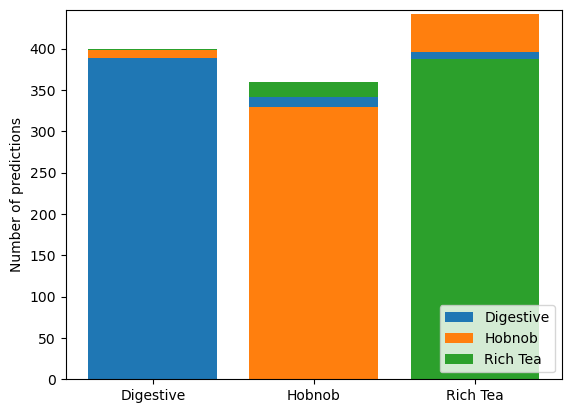

In [240]:
# plot bar chart

fig,ax = plt.subplots()

for i, biscuit in enumerate(biscuits):
    # Get values where this biscuit was predicted
    biscuit_prediction = np.where(predicted_test_vals==i, True, False)

    # Filter test values to just these biscuit predictions
    biscuit_test = true_test_vals[biscuit_prediction]
    
    # Number of correct predictions
    correct_predictions = len( biscuit_test[biscuit_test==i] )
    
    ax.bar(biscuit, correct_predictions, color=f"C{i}", label=biscuit)
    
    base = correct_predictions
    for j in range(len(biscuits)):
        if j != i:
            # NUmber of incorrect predictions, recording which biscuit was predicted instead
            incorrect_predictions = len( biscuit_test[biscuit_test==j] )
            ax.bar(biscuit, incorrect_predictions, bottom=base, color=f"C{j}")
            base += incorrect_predictions
            
ax.set_ylabel("Number of predictions")
ax.set_ylim(0, max_num_predictions+5)
ax.legend(loc="lower right");

In [241]:
# metrics

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Precision: {precision:.3f}')

recall = recall_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Recall: {recall:.3f}')

f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'F1-Score: {f1score:.3f}')

Precision: 0.923
Recall: 0.921
F1-Score: 0.921


#### microscopy measurements

The next provided dataset was generated by taking a subset, one-sixth, of the dunking-data.csv dataset used in the analysis above. However, the biscuit type label has been dropped, and instead it includes the pore radius of the biscuits. This was measured using microscopy. 

Therefore, the columns of this dataset are:
1. gamma: the tea surface tension, in N m−1.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. r: the radius of the pore, in m



In [242]:
# Show dataset

microscopy_data = pd.read_csv("microscopy-data.csv")
microscopy_data.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


In [243]:
# scaled test data (drop the microscopy true r values)
test_micro = microscopy_data.drop(['r'], axis=1)
scaled_test_micro = scaler.fit_transform(test_micro)

# Make predictions for biscuit type of each row using the best model determined above
micro_predictions = best_estimator.predict(scaled_test_micro)
len(micro_predictions)


500

In [244]:
# Determine true distribution (combine the two datasets, and compare biscuit type and measured radius)

training_merged = big_data.merge(microscopy_data, how='inner')
true_distributions = training_merged[['encoded biscuit', 'r']].copy()
true_distributions

,encoded biscuit,r
0,0,7.797961e-07
1,0,8.189772e-07
2,1,3.639434e-07
3,2,3.198697e-07
4,2,2.973448e-07
...,...,...
495,1,4.176549e-07
496,2,3.187500e-07
497,2,3.194081e-07
498,0,7.453712e-07


Text(0, 0.5, 'r')

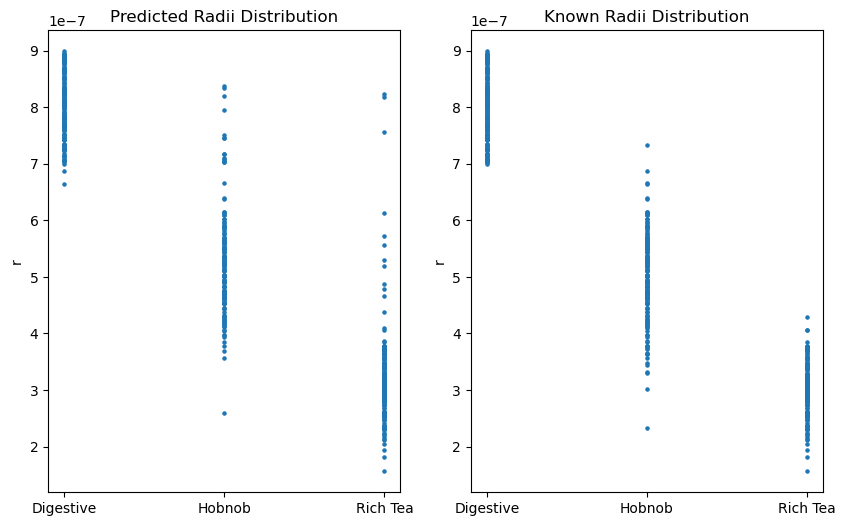

In [245]:
# distribution figure

fig,ax=plt.subplots(1,2, figsize=(10,6))

ax[0].set_title("Predicted Radii Distribution")
ax[0].scatter(micro_predictions, microscopy_data["r"], s=5)
ax[0].set_xticks(np.arange(0, len(biscuits)))
ax[0].set_xticklabels(biscuits)
ax[0].set_ylabel("r")


ax[1].set_title("Known Radii Distribution")
ax[1].scatter(true_distributions['encoded biscuit'], true_distributions["r"], s=5)
ax[1].set_xticks(np.arange(0, len(biscuits)))
ax[1].set_xticklabels(biscuits)
ax[1].set_ylabel("r")

In [246]:
np.max(true_distributions["r"])

8.991764452549078e-07

Digestive
predicted mean: 8.07e-07
true mean: 8.03e-07
predicted std: 5.8e-08
true std: 5.8e-08

Hobnob
predicted mean: 5.26e-07
true mean: 4.96e-07
predicted std: 9.77e-08
true std: 8e-08

Rich Tea
predicted mean: 3.24e-07
true mean: 3.04e-07
predicted std: 8.84e-08
true std: 4.7e-08



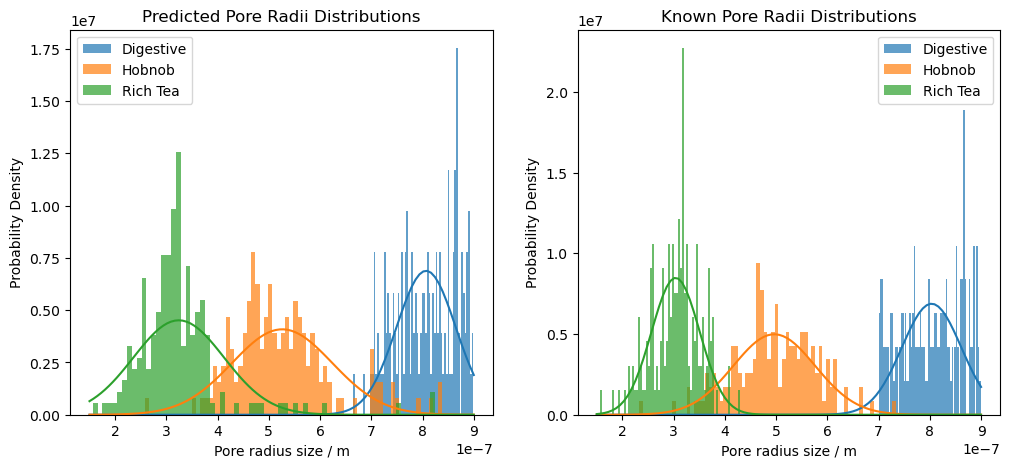

In [247]:
# plot radii distribution of each biscuit as histograms

from scipy.stats import norm

fig, ax = plt.subplots(1,2,figsize=(12,5))

biscuit_summaries = {}

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit}")
    
    # get rows where encoded biscuit was predicted as i
    map = np.where(micro_predictions==i, True, False)
    
    # get r values for these rows
    biscuit_r_data = microscopy_data["r"][map]
    
    # get true r values for these biscuits (using merged dataset)
    true_biscuit_r_data = true_distributions["r"][true_distributions['encoded biscuit']==i]
    
    # plot as 2 histograms
    ax[0].hist(biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    ax[1].hist(true_biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    
    # get mean and std of each distribution
    mean, std = norm.fit(biscuit_r_data)
    true_mean, true_std = norm.fit(true_biscuit_r_data)
    
    
    x = np.linspace(1.5e-7, 9e-7, 100)
    p = (norm.pdf(x, mean, std))
    p_true = (norm.pdf(x, true_mean, true_std))
    
    ax[0].plot(x,p, color=f"C{i}")
    ax[1].plot(x,p_true, color=f"C{i}")
    
    # add mean and std to biscuit dictionary
    biscuit_summaries[biscuit] = {'mean': mean, 'std': std}
    
    # Print comparison between predicted and true distributions
    print(f"predicted mean: {mean:.3}")
    print(f"true mean: {true_mean:.3}")
    print(f"predicted std: {std:.3}")
    print(f"true std: {true_std:.3}\n")
    
ax[0].set_xlabel("Pore radius size / m")
ax[0].set_ylabel("Probability Density")
ax[0].legend()
ax[0].set_title("Predicted Pore Radii Distributions")
ax[1].set_xlabel("Pore radius size / m")
ax[1].set_ylabel("Probability Density")
ax[1].legend()
ax[1].set_title("Known Pore Radii Distributions");

This figure shows that the model to classify biscuits is effective, and produces highly accurate distributions. 

The distributions of the models show that Digestives have the largest pore radius, then Hobnobs, and Rich Tea biscuits have the smallest radii. 

HMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM



### Time-resolved measurements
Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension (gamma) was measured at 6.78 × 10−2 N m−1.

• the contact angle (phi) was 1.45 rad.

• the tea dynamic viscosity (eta) was 9.93 × 10−4 Pa s.

The biscuit used for each measurement is unknown, and the data files are titled tr-1.csv, tr-2.csv, and tr-3.csv. Each data file contains the same information, three columns of experimental data:

1. t: the time elapsed in the measurement, in s, the dependent variable.
2. L: the length the tea has soaked up the biscuit, the independent variable, in m.
3. dL: an estimate of the uncertainty in length, also in m.

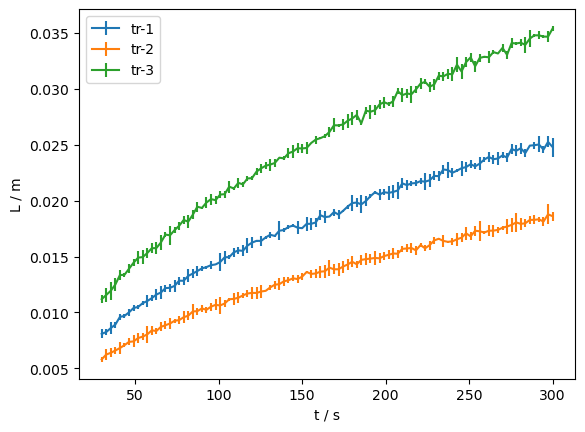

In [248]:
# show data 

fig, ax = plt.subplots()

for i in range(1,4):
    data = pd.read_csv(f"tr-{i}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    ax.errorbar(x,y,dy,label=f"tr-{i}")
    
ax.set_xlabel("t / s")
ax.set_ylabel("L / m")
ax.legend()

In [249]:
# assign time-resolved data to respective biscuit, in order from largest pore radius (Digestive) to smallest pore radius (Rich Tea)

tr_biscuits = [3,1,2]
for i, tr_val in enumerate(tr_biscuits):
    biscuit_summaries[biscuits[i]]['tr_vals'] = pd.read_csv(f"tr-{tr_val}.csv")
    
biscuit_summaries['Digestive']

{'mean': 8.069621272227054e-07,
 'std': 5.7974671287279786e-08,
 'tr_vals':              t         L        dL
 0    30.000000  0.011187  0.000371
 1    32.727273  0.011566  0.000609
 2    35.454545  0.011942  0.000809
 3    38.181818  0.012502  0.000614
 4    40.909091  0.013343  0.000480
 ..         ...       ...       ...
 95  289.090909  0.034766  0.000118
 96  291.818182  0.034769  0.000341
 97  294.545455  0.034655  0.000155
 98  297.272727  0.034646  0.000481
 99  300.000000  0.035373  0.000235
 
 [100 rows x 3 columns]}

Here, we test the effectiveness of the Washburn model. Each dataset has now been assigned to a biscuit. The pore radius of each biscuit used was not measured, so the average pore radius of each biscuit type (determined above) is used in each of the following models. 

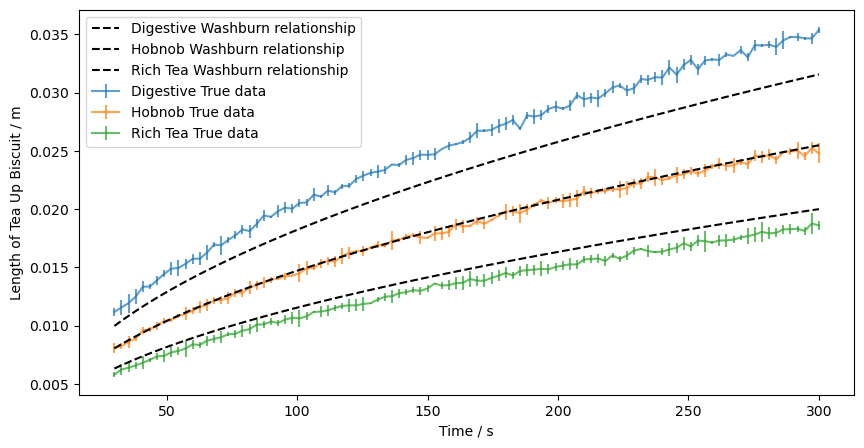

In [250]:
# washburn model fittings using average pore radii for each biscuit

fig, ax = plt.subplots(figsize=(10,5))

gamma = 6.78e-2
phi = 1.45
eta = 9.93e-4

for i, biscuit in enumerate(biscuits):
    data = biscuit_summaries[biscuit]['tr_vals']
    t = data["t"]
    L = data["L"]
    dL = data["dL"]
    
    r = biscuit_summaries[biscuit]['mean']
    
    washburn_data_rfc = washburn(gamma, phi, eta, r, t)
    ax.errorbar(t,L,dL,label=f"{biscuit} True data", alpha=0.7, color=f"C{i}")
    
    ax.plot(t, washburn_data_rfc, marker='', linestyle="--", color="black", zorder=3, label=f'{biscuit} Washburn relationship') 
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

This figure shows the Washburn relationship is likely an inaccurate model. However, there is a possibility the Digestive and Rich Tea biscuits used in these measurements had relavitely large/small pore sizes respectively. The following analysis determines the radii of the biscuits required for the Washburn model to accurately fit the real data. This will then be compared to the pore radius biscuit_summaries, to determine the likelihood these pore radii are accurate, or if the model is inaccurate. 

In [251]:
# irrelevant?

import pymc as pm
import arviz as az


def run_pymc(data, gamma=6.78e-2, phi=1.45, eta=9.93e-4, rlow=1.5e-7, rhigh=1.2e-6):
    
    D = [norm(data['L'][i], data['dL'][i]) for i in range(len(data))]
    
    with pm.Model() as model:
        gamma=gamma
        r = pm.Uniform('r', rlow, rhigh)
        phi = phi
        eta = eta
        
        L = pm.Normal('t', 
                    mu=washburn(gamma,phi,eta,r,data["t"]), 
                    sigma=data['dL'], 
                    observed=data['L'])
        
        trace = pm.sample(1000, tune=1000, chains=10, progressbar=True)
        

    az.plot_trace(trace, var_names=["r"])
    plt.tight_layout()
    plt.show()
    
    return float(trace.posterior["r"].mean())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 4 seconds.


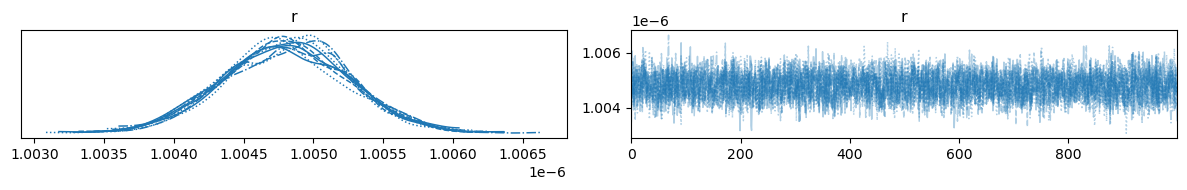

Initializing NUTS using jitter+adapt_diag...


Predicted pore radius: 1.004802173451074e-06


Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 4 seconds.


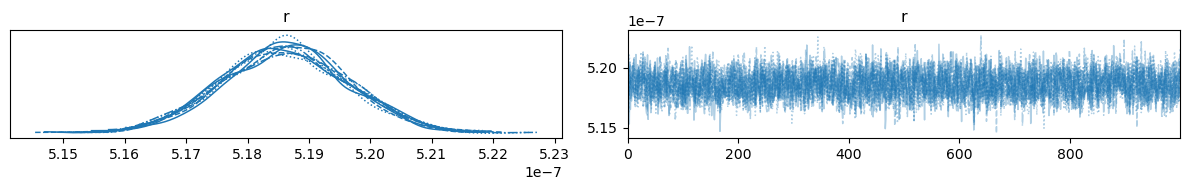

Initializing NUTS using jitter+adapt_diag...


Predicted pore radius: 5.186118176577942e-07


Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 4 seconds.


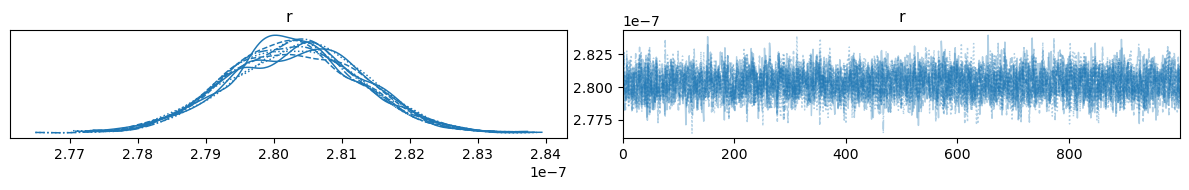

Predicted pore radius: 2.8029741835751063e-07


In [252]:
# find r for washburn to fit. 

for biscuit in biscuits:
    data = biscuit_summaries[biscuit]['tr_vals']
    
    pymc_r = run_pymc(data)
    
    print(f"Predicted pore radius: {pymc_r}")
    
    # add to summary dictionary
    biscuit_summaries[biscuit]['pymc_r'] = pymc_r


The required radius for the digestive comes out at over 1.0e-6, which is significantly greater than the mean. The following analysis determines the likelihood of each biscuit having the radius required for the Washburn model to fit effectively, using the particle size distributions determined further up. 

In [253]:
def calc_prob_in_distribution(mean, std, value):
    """
    Calculate probability of a given value to occur in a normal distribution

    Args:
        mean (float): Mean of normal distribution
        std (float): Std of normal distribution
        value (float): Value to have probability calculated 
    Returns:
        percentage (float): Probability of value or a more extreme value occuring in the provided distribution
    """
    if value > mean:
        cum_prob = 1 - norm(mean, std).cdf(value)
    elif value < mean:
        cum_prob = norm(mean, std).cdf(value)
        
    # two-tailed, and converted to a percentage
    percentage = 100*2*cum_prob
    
    return percentage

In [254]:
def calc_num_stds(mean, std, pymc_r):
    """
    Calculate number of standard deviations a given value is from the mean of a normal distribution

    Args:
        mean (float): Mean of normal distribution
        std (float): Std of normal distribution
        value (float): Value to have probability calculated 
    Returns:
        number_stds (float): number of standard deviations a given value is from the mean 
    """
    
    number_stds = abs( pymc_r - mean) /std
    
    return number_stds

In [ ]:
for biscuit in biscuits:
    print(biscuit)
    
    biscuit_dict = biscuit_summaries[biscuit]
    
    mean = biscuit_dict['mean']
    std = biscuit_dict['std'] 
    pymc_r = biscuit_dict['pymc_r']
    
    
    # Calculate probability of this radius occuring
    percentage_prob = calc_prob_in_distribution(mean, std, pymc_r)
    print(f"Probability of this value or a more extreme value occuring: {percentage_prob:.2f} %")
    
    # Calculate number of standard devisations of value from mean
    num_stds = calc_num_stds(mean, std, pymc_r)
    print(f"Number of stds from mean: {num_stds:.3}")
    
    biscuit_summaries[biscuit]['value_prob'] = percentage_prob
    biscuit_summaries[biscuit]['num_stds'] = num_stds


Digestive
probability of this value or more extreme occuring: 0.06 %
Number of stds from mean: 3.41
Hobnob
probability of this value or more extreme occuring: 93.92 %
Number of stds from mean: 0.0763
Rich Tea
probability of this value or more extreme occuring: 61.97 %
Number of stds from mean: 0.496


From this analysis, it is clear that the Washburn equation is not a good prediction model. The probability of the Washburn model being correct for Digestives is extremely low, as the chance of the required radius occuring is less than 0.06%. This suggests there is instead something wrong with the model. 

The Washburn model effectively predicts the relationship between L and t for Hobnobs. Furthermore, the model for the Rich Tea biscuit is likely correct, as the required radius for the probability is relatively likely to occur. However, the predicted model for the Digestives is very unlikely, which suggests the model can and should be improved.

### An improved model?

In [256]:
def likelihood(params, model):
    """
    A general likelihood function for a model with Gaussian errors.
    
    :param params: The parameters of the model.
    :param model: The model function.
    
    :return: The likelihood of the model given the data.
    """
    model_y = model(data['t'], params)
    # print(model_y.shape)
    return np.sum([d.logpdf(m) for d, m in zip(data_distribution, model_y)])

In [257]:
def prior_transform_one(u):
    """
    Transform the uniform random variables `u` to the model parameters.
    
    :param u: Uniform random variables
    
    :return: Model parameters
    """
    return [p.ppf(u_) for p, u_ in zip(tr3_priors, u)]

In [258]:
def model_one(t, params):
    """
    A simpler single Gaussian model.
    
    :param t: The x values
    :param params: The model parameters
    
    :return: The y values
    """
    t=t.values.reshape(-1,1)
    r = biscuit_summaries[biscuit]['mean']
    # print(t)
    # print(params[0])
    gamma=6.78e-2
    phi=1.45
    eta=9.93e-4 
    
    L = washburn(gamma,phi,eta,r,t)
    
    # L at time t.
    return L

In [259]:
def likelihood_one(params):
    """
    The likelihood function for the simpler model.
    
    :param params: The model parameters
    
    :return: The likelihood
    """
    return likelihood(params, model_one)

In [260]:
def prior_transform_two(u):
    """
    Transform the uniform random variables `u` to the model parameters for the more complex model.
    
    :param u: Uniform random variables
    
    :return: Model parameters
    """
    return [p.ppf(u_) for p, u_ in zip(tr3_priors_two, u)]

In [261]:
def model_two(t, params):
    """
    A simpler single Gaussian model.
    
    :param t: The x values
    :param params: The model parameters
    
    :return: The y values
    """
    t=t.values.reshape(-1,1)
    a = params[0]
    r =  biscuit_summaries[biscuit]['mean']
    gamma=6.78e-2
    phi=1.45
    eta=9.93e-4 
    
    L = washburn(gamma,phi,eta,r,t)
    
    # L_corrected = (b*r+a)*L
    L_corrected = (a)*L 
    
    # L at time t.
    return L_corrected

In [262]:
def likelihood_two(params):
    """
    The likelihood function for the more complex model.
    
    :param params: The model parameters
    
    :return: The likelihood
    """
    return likelihood(params, model_two)



In [266]:
# WORKING !!

import ultranest

import numpy as np
from scipy.stats import uniform, norm

log_Bs = []

tr3_priors = []  

for biscuit in biscuits:
    data = biscuit_summaries[biscuit]['tr_vals']

    data_distribution = [norm(loc=loc, scale=scale) for loc, scale in zip(data['L'], data['dL'])]

    sampler_one = ultranest.ReactiveNestedSampler([], likelihood_one, prior_transform_one)
    sampler_one.run(show_status=False)
    sampler_one.print_results()

    tr3_priors_two = [uniform(0, 10)]

    sampler_two = ultranest.ReactiveNestedSampler(['a'], likelihood_two, prior_transform_two)
    sampler_two.run(show_status=False)
    sampler_two.print_results()
    
    biscuit_summaries[biscuit]['correction'] = sampler_two.results['posterior']['mean'][0]
    
    log_B = sampler_two.results['logz'] - sampler_one.results['logz']
    print(f"log_B: {log_B:.3}")
    
    log_Bs.append(log_B)

[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-1e+05  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = -1.055e+05 +- 1.821e-11
[ultranest] Effective samples strategy satisfied (ESS = 400.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 40 minimum live points (dlogz from 0.00 to 0.00, need <0.5)
[ultranest]   logZ error budget: single: inf bs:0.00 tail:0.69 total:0.69 required:<0.50
[ultranest] done iterating.

logZ = -105479.607 +- 0.693
  single instance: logZ = -105479.607 +- nan
  bootstrapped   : logZ = -105479.607 +- -0.000
  tail           : logZ = +- 0.693
insert order U test : converged: True correlation: inf iterations


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=4e+02  
[ultranest] Likelihood function evaluations: 5820
[ultranest]   logZ = 410.1 +- 0.1212
[ultranest] Effective samples strategy satisfied (ESS = 1261.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.12 tail:0.03 total:0.13 required:<0.50
[ultranest] done iterating.

logZ = 410.094 +- 0.227
  single instance: logZ = 410.094 +- 0.151
  bootstrapped   : logZ = 410.117 +- 0.225
  tail           : logZ = +- 0.033
insert order U test : converged: True correlation: inf iterations

    a                   : 1.11479│ ▁ ▁▁▁▁▁▁▁▂▂▂▃▅▅▇▇▇▆▇▇▇▇▅▅▄▄▃▂▁▁▁▁▁▁▁▁ │1.11682    1.11586 +- 0.00026

log_B: 1.06e+05
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=6e+02  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = 630 +- 4.641e-14
[

[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 5168
[ultranest]   logZ = 647.6 +- 0.1039
[ultranest] Effective samples strategy satisfied (ESS = 1240.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.04 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = 647.650 +- 0.182
  single instance: logZ = 647.650 +- 0.140
  bootstrapped   : logZ = 647.634 +- 0.178
  tail           : logZ = +- 0.038
insert order U test : converged: True correlation: inf iterations

    a                   : 0.98929│ ▁▁▁▁▁▁▁▁▂▂▃▄▅▇▇▇▇▆▆▅▄▃▃▂▁▂▁▁▁▁▁▁▁▁  ▁ │0.99761    0.99291 +- 0.00097

log_B: 17.7
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-3e+02  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = -296.6 +- 6.884e-14
[

[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 4978
[ultranest]   logZ = 649.2 +- 0.08828
[ultranest] Effective samples strategy satisfied (ESS = 1250.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.09 tail:0.03 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = 649.176 +- 0.283
  single instance: logZ = 649.176 +- 0.134
  bootstrapped   : logZ = 649.166 +- 0.281
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    a                   : 0.9235│ ▁▁▁▁▁▁▁▁▁▂▄▃▄▅▆▇▇▇▇▆▇▅▆▅▃▂▂▁▁▁▁▁▁▁  ▁ │0.9367    0.9299 +- 0.0016

log_B: 9.46e+02


In [267]:
biscuit_summaries[biscuit].values()
# biscuit_summaries[biscuit].keys()

dict_values([3.241525771540829e-07, 8.837319573133054e-08,              t         L        dL
0    30.000000  0.005809  0.000228
1    32.727273  0.006243  0.000514
2    35.454545  0.006394  0.000393
3    38.181818  0.006601  0.000323
4    40.909091  0.006822  0.000566
..         ...       ...       ...
95  289.090909  0.018278  0.000407
96  291.818182  0.018326  0.000248
97  294.545455  0.018127  0.000368
98  297.272727  0.018770  0.000881
99  300.000000  0.018605  0.000395

[100 rows x 3 columns], 2.8029741835751063e-07, 0.92991733847568])

In [268]:
# table1 = pd.DataFrame(columns=biscuit_summaries[biscuit].keys())
# table1.loc[biscuit] = list(biscuit_summaries[biscuit].values())
# table1

In [269]:
# # table1 = pd.DataFrame()
# table1 = pd.DataFrame(columns=biscuit_summaries[biscuit].keys())
# for biscuit in biscuits:
#     biscuit_summaries[biscuit].pop('tr_vals', None)
#     table1.loc[biscuit] = list(biscuit_summaries[biscuit].values())
    
# table1.to_csv('probability table')



In [270]:
# new = biscuit_summaries['Rich Tea'].pop('tr_vals', None)
# biscuit_summaries

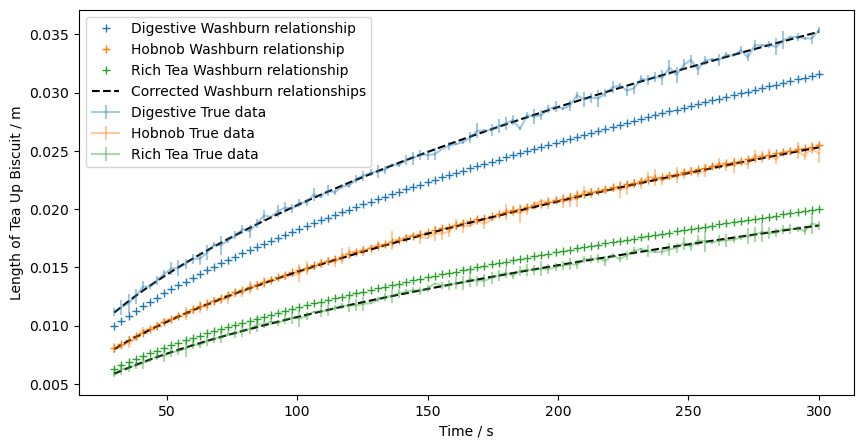

In [273]:
# corrected washburn model fittings

from sklearn.metrics import mean_squared_error

table2 = pd.DataFrame(columns=(['log_B', 'Original model MSE', 'Corrected model MSE']))


fig, ax = plt.subplots(figsize=(10,5))

for i, biscuit in enumerate(biscuits):
    data = biscuit_summaries[biscuit]['tr_vals']
    t = data["t"]
    L = data["L"]
    dL = data["dL"]
    
    washburn_data_rfc = washburn(gamma, phi, eta, biscuit_summaries[biscuit]['mean'], t )
    ax.errorbar(x,L,dL,label=f"{biscuit} True data", alpha=0.4, color=f"C{i}", zorder=15)
    
    ax.plot(t, washburn_data_rfc, marker='+', linestyle='', color=f"C{i}", zorder=3, label=f'{biscuit} Washburn relationship') 
    
    correction = biscuit_summaries[biscuit]['correction']
    if i == len(biscuits)-1:
        label = 'Corrected Washburn relationships'
    else:
        label=None
        
    corrected_model = (correction)*washburn_data_rfc
    ax.plot(t, corrected_model, linestyle='--', color="black", zorder=5, label=label) 
    
    mse_original = mean_squared_error(L, washburn_data_rfc)
    mse_corrected = mean_squared_error(L, corrected_model)
    
    table2.loc[biscuit] = [log_Bs[i], mse_original, mse_corrected]
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

table2.to_csv('model_comparisons.csv', index_label='Biscuit Type')

In [274]:
table2

,log_B,Original model MSE,Corrected model MSE
Digestive,105889.701595,7.303644e-06,5.605481e-08
Hobnob,17.690544,5.210820e-08,3.427070e-08
Rich Tea,945.740202,1.153473e-06,1.733368e-08


Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension was measured at 6.78 × 10−2 N m−1.

• the contact angle was 1.45 rad.

• the tea dynamic viscosity was 9.93 × 10−4 Pa s.

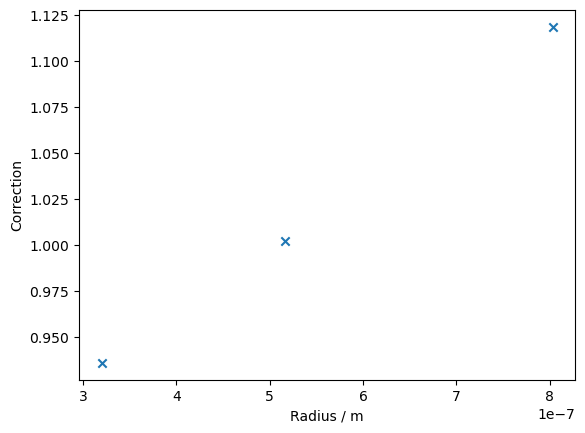

In [ ]:
fig, ax = plt.subplots()

radii_mean = np.zeros(len(biscuits))
corrections = np.zeros(len(biscuits))
for i, biscuit in enumerate(biscuits):
    radii_mean[i] = (biscuit_summaries[biscuit]['mean'])
    corrections[i] = (biscuit_summaries[biscuit]['correction'])
    
ax.scatter(radii_mean, corrections, marker='x')

ax.set_xlabel('Radius / m')
ax.set_ylabel('Correction');

These corrections look like they may have a linear relationship, which would produce a neat wrapper for relating the correction function to readius. The following code determines the relationship and plots it. However, it should be considered that this relationship is very unreliable as there are only three data points. 

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

x = radii_mean.reshape(-1, 1)
y = corrections.reshape(-1, 1)

model.fit(x,y)

print(model.coef_)
print(model.intercept_)

[[379708.24060574]]
[0.81136511]


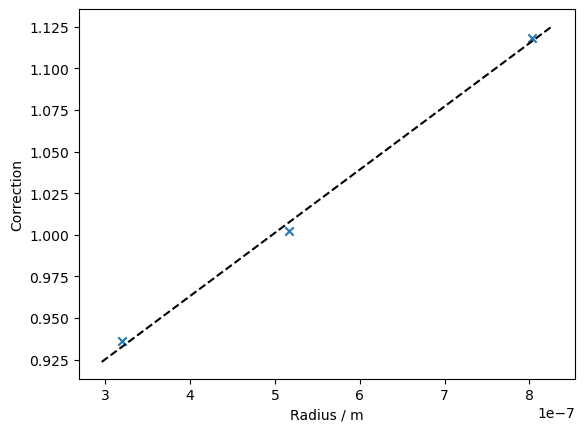

In [ ]:
fig, ax = plt.subplots()

radii_mean = np.zeros(len(biscuits))
corrections = np.zeros(len(biscuits))
for i, biscuit in enumerate(biscuits):
    radii_mean[i] = (biscuit_summaries[biscuit]['mean'])
    corrections[i] = (biscuit_summaries[biscuit]['correction'])
    
ax.scatter(radii_mean, corrections, marker='x')

# Plot linear regression model
x_vals = np.array(ax.get_xlim())
y_vals = model.intercept_[0] + model.coef_[0][0] * x_vals
ax.plot(x_vals, y_vals, linestyle='--', color='black')

ax.set_xlabel('Radius / m')
ax.set_ylabel('Correction');

In [ ]:
predictions = model.predict(radii_mean.reshape(-1,1))

from sklearn.metrics import r2_score

r2_score(predictions, corrections)

0.9975027617440869

This figure suggests there may be a linear relationship between the correction factor and the pore radius of a biscuit. However, with only 3 data points, this relationship is very unreliable. This unreliability is enhanced by the fact that the true pore radii of each biscuit used in this analysis was not known. 

## polynomial regression

In [ ]:
def reg_model(r, t):
    return (1.54e+02*r + -1.8e+07*(r**2) + 2.16e-05)*t + (-0.254*r + 9.33e+04*(r**2) + -3.76e-09)*(t**2) + (3.96e+03*r + 3.74e+09*(r**2) + 0.00272)

Digestive 0
8.031823859531258e-07
RMSE for Washburn model: 0.00276
RMSE for Polynomial regression model: 0.00153


Hobnob 1
5.164259665375461e-07
RMSE for Washburn model: 0.000189
RMSE for Polynomial regression model: 0.000923


Rich Tea 2
3.199289649727385e-07
RMSE for Washburn model: 0.000978
RMSE for Polynomial regression model: 0.00093




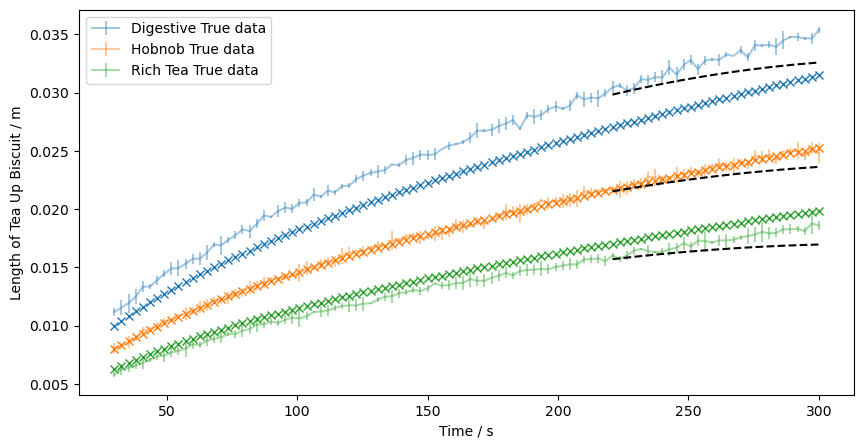

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(10,5))

tr_list = [3,1,2]
poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit} {i}")
    
    biscuit_dict = biscuit_summaries[biscuit]
    print(biscuit_dict['mean'])
    
    
    data = biscuit_dict['tr_vals']
    x = data["t"].values.reshape(-1,1)
    y = data["L"]
    dy = data["dL"]
    
    train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=False)
    
    X_train = poly.fit_transform(train["t"].values.reshape(-1,1))
    y_train = train['L']
    
    model.fit(X_train, y_train)
    
    X_test = test['t'].values.reshape(-1,1)
    X_test_ = poly.fit_transform(X_test)
    
    y_test = test['L'].values
    
    washburn_data_rfc = washburn(gamma, phi, eta, biscuit_dict['mean'], data["t"] )
    ax.errorbar(x,y,dy,label=f"{biscuit} True data", alpha=0.4, color=f"C{i}")
    ax.plot(test['t'], model.predict(X_test_), linestyle='--', marker='', c='black', zorder=4)
    ax.plot(data['t'], washburn_data_rfc, linestyle='', marker='x', c=f'C{i}', zorder=3)
    # ax.scatter(test['t'], y_test)
    
    mse_wash = np.sqrt(mean_squared_error(y , washburn_data_rfc))
    mse_reg =  np.sqrt(mean_squared_error(y_test , model.predict(X_test_)))
    
    print(f"RMSE for Washburn model: {mse_wash:.3}")
    print(f"RMSE for Polynomial regression model: {mse_reg:.3}")
    print(f"\n")
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

Digestive
8.031823859531258e-07
RMSE for Washburn model: 0.00276
RMSE for Polynomial regression model: 0.000331


Hobnob
5.164259665375461e-07
RMSE for Washburn model: 0.000189
RMSE for Polynomial regression model: 0.000239


Rich Tea
3.199289649727385e-07
RMSE for Washburn model: 0.000978
RMSE for Polynomial regression model: 0.00019




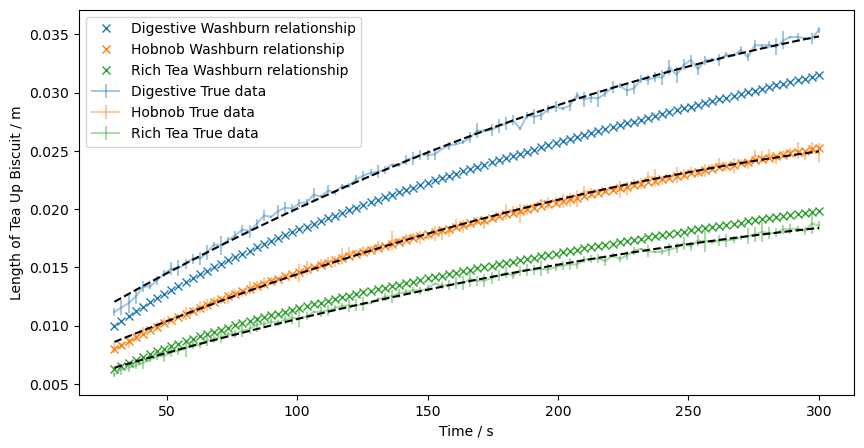

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(10,5))

poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit}")
    
    biscuit_dict = biscuit_summaries[biscuit]
    print(biscuit_dict['mean'])
    
    
    data = biscuit_dict['tr_vals']
    x = data["t"].values.reshape(-1,1)
    y = data["L"]
    dy = data["dL"]
    
    train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
    
    X_train = poly.fit_transform(train["t"].values.reshape(-1,1))
    y_train = train['L']
    
    model.fit(X_train, y_train)
    
    X_test = data['t'].values.reshape(-1,1)
    X_test_ = poly.fit_transform(X_test)
    
    y_test = test['L'].values
    
    washburn_data_rfc = washburn(gamma, phi, eta, biscuit_dict['mean'], data["t"] )
    ax.errorbar(x,y,dy,label=f"{biscuit} True data", alpha=0.4, color=f"C{i}")
    ax.plot(data['t'], model.predict(X_test_), linestyle='--', marker='', c='black', zorder=4)
    # ax.scatter(test['t'], y_test)
    
    ax.plot(data["t"], washburn_data_rfc, marker='x', linestyle="", color=f"C{i}", zorder=3, label=f'{biscuit} Washburn relationship') 
    
    mse_wash = np.sqrt(mean_squared_error(y , washburn_data_rfc))
    mse_reg =  np.sqrt(mean_squared_error(y , model.predict(X_test_)))
    
    print(f"RMSE for Washburn model: {mse_wash:.3}")
    print(f"RMSE for Polynomial regression model: {mse_reg:.3}")
    # print(model.coef_)
    print(f"\n")
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

## Neural network



In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class RNNModel(nn.Module):
    """
    Create a simple RNN model with a single RNN layer, a dropout layer, and a fully connected layer.
    
    :param input_size: The number of features in the input data.
    :param hidden_size: The number of features in the hidden state.
    :param output_size: The number of features in the output data.
    :param dropout: The dropout rate.
    """
    def __init__(self, input_size=2, hidden_size=16, output_size=1, num_layers=2, dropout=0):
        super(RNNModel, self).__init__()
        
        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,  
            nonlinearity='tanh', 
            bias=True 
        )
        
        self.dropout = nn.Dropout(dropout) 
        self.fc = nn.Linear(hidden_size, output_size)  
        
    def forward(self, x):
        """
        Forward pass of the RNN model.
        
        :param x: The input data.
        :return: The output data.
        """
        if type(x) is np.ndarray:
            x = torch.tensor(x, dtype=torch.float32)[:, np.newaxis]
        rnn_out, _ = self.rnn(x)  
        rnn_out = self.dropout(rnn_out[:, -1]) 
        out = torch.sigmoid(self.fc(rnn_out)) 
        return out
    
    def perform_training(self, data, labels, epochs=100, lr=0.001):
        """
        Perform training of the RNN model.
        
        :param data: The input data.
        :param labels: The output data.
        :param epochs: The number of epochs.
        :param lr: The learning rate.
        """
        loss_fn = nn.BCELoss()
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)

        Xtrain_tensor = torch.tensor(data, dtype=torch.float32)[:, np.newaxis]
        ytrain_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)  # Reshape for BCELoss

        batch_size = 16
        train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            self.train()  
            running_loss = 0.0
            for X_batch, y_batch in train_loader:
                optimiser.zero_grad()  
                outputs = self(X_batch)  
                loss = loss_fn(outputs, y_batch)  
                loss.backward()
                optimiser.step()  
                running_loss += loss.item()
            
            avg_loss = running_loss / len(train_loader) 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

class LSTMModel(nn.Module):
    """
    Create a simple LSTM model with a single LSTM layer, a dropout layer, and a fully connected layer.
    
    :param input_size: The number of features in the input data.
    :param hidden_size: The number of features in the hidden state.
    :param output_size: The number of features in the output data.
    :param dropout: The dropout rate.
    :param initial_bias: The initial bias for the fully connected layer.
    """
    def __init__(self, input_size=2, hidden_size=16, output_size=1, num_layers=1, dropout=0):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,  
            hidden_size=hidden_size,
            num_layers=num_layers,
            # proj_size = proj_size,
            batch_first=True,  
            bias=True  
        )
        
        self.dropout = nn.Dropout(dropout)  
        self.fc = nn.Linear(hidden_size, output_size)  
        
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        """
        Forward pass of the LSTM model.
        
        :param x: The input data.
        :return: The output data.
        """
        if type(x) is np.ndarray:
            x = torch.tensor(x, dtype=torch.float32)[:, np.newaxis]
        lstm_out, _ = self.lstm(x) 
        lstm_out = self.dropout(lstm_out[:, -1])  
        out = torch.sigmoid(self.fc(lstm_out))  
        return out

    def perform_training(self, data, labels, epochs=100, lr=0.001):
        """
        Perform training of the LSTM model.
        
        :param data: The input data.
        :param labels: The output data.
        :param epochs: The number of epochs.
        :param lr: The learning rate.
        """
        criterion = nn.BCELoss()  
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        batch_size = 16

        Xtrain_tensor = torch.tensor(data, dtype=torch.float32)[:, np.newaxis]
        ytrain_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)  # Reshape for BCELoss

        train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()  
                outputs = self(X_batch)  
                loss = criterion(outputs, y_batch) 
                loss.backward() 
                optimizer.step() 
                running_loss += loss.item()
            
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

In [ ]:
# Load in data

tr_1 = pd.read_csv("tr-1.csv")
tr_2 = pd.read_csv("tr-2.csv")
tr_3 = pd.read_csv("tr-3.csv")

tr_3.head()

,t,L,dL
0,30.000000,0.011187,0.000371
1,32.727273,0.011566,0.000609
2,35.454545,0.011942,0.000809
3,38.181818,0.012502,0.000614
4,40.909091,0.013343,0.000480


In [ ]:
tr_1['r'] = 5.22e-7
tr_2['r'] = 3.21e-7
tr_3['r'] = 8.04e-7
tr_1

,t,L,dL,r
0,30.000000,0.008087,0.000392,5.220000e-07
1,32.727273,0.008253,0.000270,5.220000e-07
2,35.454545,0.008607,0.000501,5.220000e-07
3,38.181818,0.008920,0.000267,5.220000e-07
4,40.909091,0.009604,0.000274,5.220000e-07
...,...,...,...,...
95,289.090909,0.024948,0.000307,5.220000e-07
96,291.818182,0.025015,0.000711,5.220000e-07
97,294.545455,0.024558,0.000322,5.220000e-07
98,297.272727,0.025243,0.000489,5.220000e-07


In [ ]:
tr_combined = pd.concat([tr_1, tr_2, tr_3])
tr_combined = pd.concat([tr_1.iloc[:70], tr_2.iloc[:70], tr_3.iloc[:70]])
tr_combined

,t,L,dL,r
0,30.000000,0.008087,0.000392,5.220000e-07
1,32.727273,0.008253,0.000270,5.220000e-07
2,35.454545,0.008607,0.000501,5.220000e-07
3,38.181818,0.008920,0.000267,5.220000e-07
4,40.909091,0.009604,0.000274,5.220000e-07
...,...,...,...,...
65,207.272727,0.029774,0.000282,8.040000e-07
66,210.000000,0.029423,0.000642,8.040000e-07
67,212.727273,0.029571,0.000431,8.040000e-07
68,215.454545,0.029502,0.000748,8.040000e-07


In [ ]:
import pandas as pd

# train, test = train_test_split(tr_combined, test_size=0.3)

t_train = tr_combined[['t', 'r']]
L_train = tr_combined['L']
# t_test = test[['t', 'r']]
# L_test = test['L']

rnn = RNNModel()
rnn.perform_training(t_train.values, L_train.values, epochs=100)
lstm = LSTMModel()
lstm.perform_training(t_train.values, L_train.values, epochs=100)

rnn.eval()
rnn_y_pred = rnn.forward(tr_2[['t', 'r']].iloc[50:].values).detach().numpy().reshape(-1)
# rnn_y_pred = rnn.forward(t_test.values).reshape(-1)
lstm.eval()
lstm_y_pred = lstm.forward(tr_2[['t', 'r']].iloc[50:].values).detach().numpy().reshape(-1)
# lstm_y_pred = lstm.forward(t_test.values).reshape(-1)


Epoch 1/100, Loss: 0.5613
Epoch 2/100, Loss: 0.3994
Epoch 3/100, Loss: 0.2963
Epoch 4/100, Loss: 0.2327
Epoch 5/100, Loss: 0.1929
Epoch 6/100, Loss: 0.1663
Epoch 7/100, Loss: 0.1472
Epoch 8/100, Loss: 0.1329
Epoch 9/100, Loss: 0.1229
Epoch 10/100, Loss: 0.1140
Epoch 11/100, Loss: 0.1077
Epoch 12/100, Loss: 0.1048
Epoch 13/100, Loss: 0.1003
Epoch 14/100, Loss: 0.0966
Epoch 15/100, Loss: 0.0937
Epoch 16/100, Loss: 0.0933
Epoch 17/100, Loss: 0.0906
Epoch 18/100, Loss: 0.0908
Epoch 19/100, Loss: 0.0888
Epoch 20/100, Loss: 0.0900
Epoch 21/100, Loss: 0.0865
Epoch 22/100, Loss: 0.0870
Epoch 23/100, Loss: 0.0871
Epoch 24/100, Loss: 0.0854
Epoch 25/100, Loss: 0.0854
Epoch 26/100, Loss: 0.0847
Epoch 27/100, Loss: 0.0848
Epoch 28/100, Loss: 0.0849
Epoch 29/100, Loss: 0.0866
Epoch 30/100, Loss: 0.0845
Epoch 31/100, Loss: 0.0836
Epoch 32/100, Loss: 0.0861
Epoch 33/100, Loss: 0.0853
Epoch 34/100, Loss: 0.0840
Epoch 35/100, Loss: 0.0832
Epoch 36/100, Loss: 0.0863
Epoch 37/100, Loss: 0.0839
Epoch 38/1

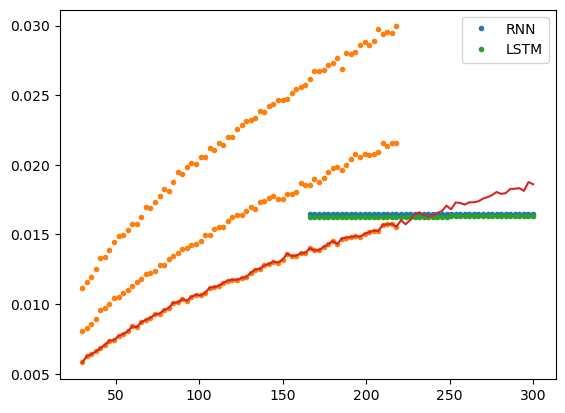

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tr_1['t'].iloc[50:], rnn_y_pred, '.', label='RNN')
plt.plot(tr_combined['t'], tr_combined['L'], '.')
plt.plot(tr_2['t'].iloc[50:], lstm_y_pred, '.', label='LSTM')
plt.plot(tr_2['t'], tr_2['L'])
plt.legend()
plt.show()

### Conclusion

The corresponding report will outline how the data produced can be used in future data-driven investigations. 